# Detect Mask Image

This notebook uses the trained neural network to detect facemasks from user-supplied images. 

In [1]:
# MODIFY ALL COMMENTS IN THIS NOTEBOOK SO THAT THEY APPEAR AS HEADINGS ABOVE THE CELLS, AS IN THE ABOVE. 

# USAGE
# python detect_mask_image.py --image examples/example_01.png

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
import hublib
from hublib.ui import FileUpload, Download
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import Image
from IPython.display import display
from io import BytesIO
import PIL.Image

<IPython.core.display.Javascript object>

In [3]:
# MODIFY THIS SO THAT: 
# 1. The user can supply their own image via direct upload or pull an example from the example directory  
# 2. The user can choose either the default model or one that they trained themselves.  
# 3. Let the user modify the confidence level from 0.5 

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", 
	default="examples/example-01.png",
	help="path to input image")
ap.add_argument("-w", "--wace", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
ap.add_argument("-f", "--face", type=str,
	help="runtime kernel json location")
args = vars(ap.parse_args())

# print(te)

In [4]:
global filelist
filelist = []

#face = "face_detector"
#model = "mask_detector.model"
#confidence = 0.5

def mycb(w,fnames):
    global fnm
    fnm=fnames[0]
    fbase = os.path.basename(fnm)
    #if os.path.isdir('data/' + os.path.splitext(fbase)[0]) == False:
    #    os.makedirs('data/' + os.path.splitext(fbase)[0])
    filelist.append(fbase)
    os.rename(fnm, 'data/' + fbase)
    w.reset()

f = FileUpload("Upload Image", 
               "< Description >",
               cb=mycb,
               maxsize=10000000)
f

In [9]:
print('fnm: ', fnm)
print('filelist:', filelist)
print('face: ', args["wace"])
print('model: ', args["model"])
print('image path: ', 'data/' + filelist[-1])

fnm:  tmpdir/example_01.png
filelist: ['example_03.png', 'example_01.png']
face:  face_detector
model:  mask_detector.model
image path:  data/example_01.png


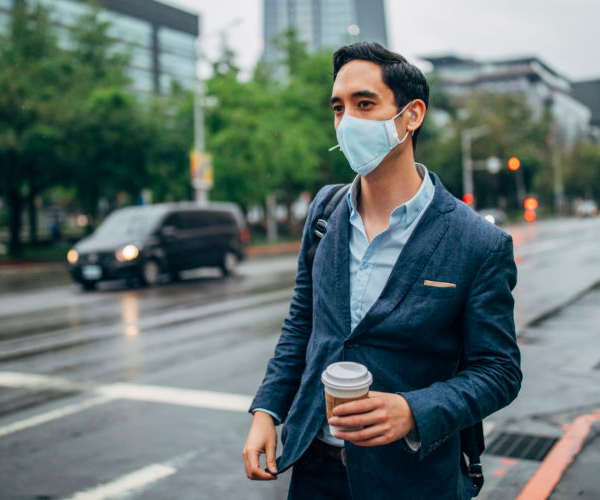

In [10]:
Image(filename= 'data/' + filelist[-1] ) 

In [11]:
# MODIFY THIS PART SO THAT 
# 1. Provide the user to download the resulting image. 

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["wace"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["wace"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

# load the input image from disk, clone it, and grab the image spatial
# dimensions
#image = cv2.imread('data/' + filelist[-1])
#image
#print(type(image))

[INFO] loading face detector model...
[INFO] loading face mask detector model...


[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


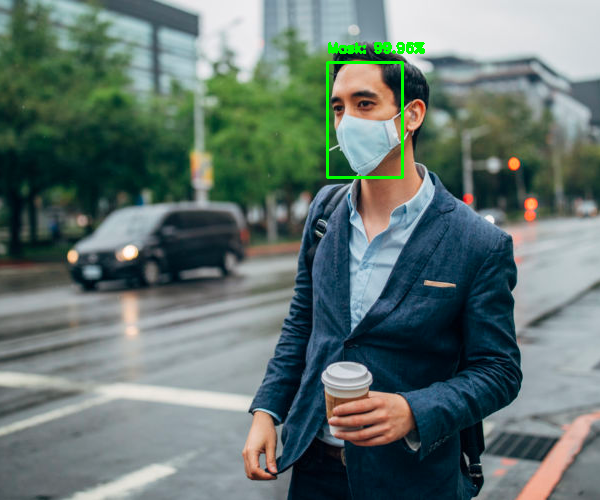

In [12]:
# MODIFY THIS PART SO THAT 
# 1. Provide the user to download the resulting image. 

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["wace"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["wace"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('data/' + filelist[-1])
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

#print(type(image))
#print(image.size)
#print(image.shape)
#print(image[200][100])

image_2 = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
k = BytesIO()
PIL.Image.fromarray(image_2).save(k, 'png')
display(Image(data=k.getvalue()))

#image_3 = image.tobytes()
#print(type(image_3))
#Image(data=image_3) 

# show the output image
# i = Image(data=image) 
# IPython.display.display(i)
#cv2.imshow("Output", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()